In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np

import os
import zipfile

import urllib.request as ur

import glob
import torch.optim as optim
from PIL import Image
import torch.utils.data as data
from torchvision import transforms, models
import torch.backends.cudnn as cudnn
import random
import matplotlib.pyplot as plt

from tqdm import tqdm

data_dir = './'


In [2]:
torch.manual_seed(25)
np.random.seed(25)
random.seed(25)

cudnn.benchmark = False
cudnn.deterministic = True



### Download and extract data

In [3]:
url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'

save_path = os.path.join(data_dir, 'hymenoptera_data.zip')

if not os.path.exists(save_path):
    ur.urlretrieve(url, save_path)
    
    zip_file = zipfile.ZipFile(save_path)
    
    zip_file.extractall(data_dir)
    
    zip_file.close()
    os.remove(save_path)


In [4]:
!rm hymenoptera_data.zip

rm: cannot remove 'hymenoptera_data.zip': No such file or directory


In [5]:
!ls hymenoptera_data/train/ants | wc -l

124


### Transform image

In [6]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale = (0.5,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ]),
            
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ])
        }
    
    def __call__(self,img,phase = 'train'):
        return self.transform[phase](img)

In [7]:
! ls ./hymenoptera_data/

train  val


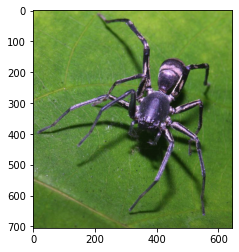

[[[ 0.02269024  0.90546227 -0.79355115]
  [ 0.00556549  0.90546227 -0.8109804 ]
  [ 0.02269024  0.88795525 -0.79355115]
  ...
  [ 0.673431    1.3781513  -0.5844008 ]
  [ 0.74193     1.4131653  -0.5669716 ]
  [ 0.74193     1.4131653  -0.5844008 ]]

 [[ 0.02269024  0.90546227 -0.79355115]
  [ 0.02269024  0.90546227 -0.8109804 ]
  [ 0.03981499  0.90546227 -0.7586928 ]
  ...
  [ 0.673431    1.3606442  -0.6192592 ]
  [ 0.70768046  1.3781513  -0.6192592 ]
  [ 0.70768046  1.3781513  -0.6192592 ]]

 [[ 0.00556549  0.87044823 -0.8458387 ]
  [ 0.00556549  0.87044823 -0.8109804 ]
  [ 0.02269024  0.87044823 -0.74126357]
  ...
  [ 0.6563062   1.2731093  -0.6192592 ]
  [ 0.6220567   1.2731093  -0.60182995]
  [ 0.63918144  1.2906163  -0.5844008 ]]

 ...

 [[-1.0561693  -0.32002798 -1.2989979 ]
  [-0.95342064 -0.23249297 -1.1944225 ]
  [-0.88492167 -0.21498597 -1.1421349 ]
  ...
  [-0.7650484  -0.03991595 -1.1421349 ]
  [-0.79929787 -0.07492995 -1.1421349 ]
  [-0.8506721  -0.14495796 -1.1769934 ]]

 [

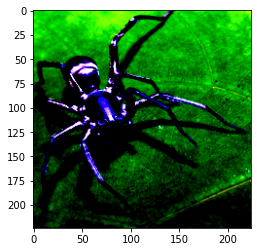

In [8]:
# test transform

img_path = './hymenoptera_data/train/ants/VietnameseAntMimicSpider.jpg'
img = Image.open(img_path)

plt.imshow(img)
plt.show()


resize = 224
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]

tf_img = ImageTransform(resize, mean, std)
img_trans = tf_img(img, phase = 'train')

img_trans = img_trans.numpy().transpose(1,2,0)
print(img_trans)
img_trans = np.clip(img_trans, 0 ,1)
print(img_trans)

plt.imshow(img_trans)
plt.show()



In [9]:
#
def make_datapath_list(phase = 'train'):
    root_path = "./hymenoptera_data/"
#     print(root_path + phase)
    target_path = os.path.join(root_path, phase, "**/*")
    
    path_list = []
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list

In [10]:
train_list = make_datapath_list(phase = 'train')
val_list = make_datapath_list(phase = 'val')

In [11]:
class Dataset(data.Dataset):
    def __init__(self, file_list, transform = None, phase = 'train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, indx):
        img_path = self.file_list[indx]
        img = Image.open(img_path)
        
        img = self.transform(img, self.phase)
        
        label = img_path.split('/')[-2]
        
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1
        
        return img, label

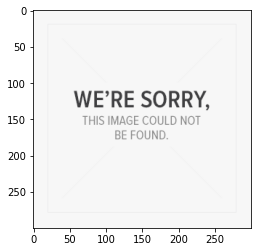

In [12]:
# remove wrong image

path = ''
for img_path in train_list:
    img = Image.open(img_path)
    if len(img.getbands()) != 3:
        path = img_path
        plt.imshow(img)
        plt.show()


train_list.remove(path)

In [13]:
train_dataset = Dataset(train_list,transform =ImageTransform(resize, mean, std),phase = 'train')
valid_dataset = Dataset(val_list,transform =ImageTransform(resize, mean, std),phase = 'val')

244
AxesImage(54,36;334.8x217.44) label: 0


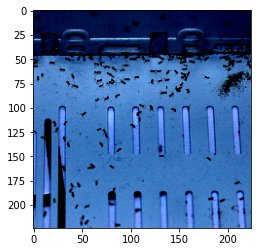

In [14]:
print(len(train_dataset))
print(plt.imshow(train_dataset[0][0].numpy().transpose(1,2,0)), "label: " + str(train_dataset[0][1]))

In [15]:
batch_size = 6

train_dataloader = data.DataLoader(train_dataset,batch_size = batch_size, shuffle = True)
val_dataloader = data.DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)

dataloader_dict = {
    'train': train_dataloader,
    'val': val_dataloader
}

In [16]:
batch_iterator = iter(dataloader_dict['train'])
inputs, labels = next(batch_iterator)

In [17]:
print(inputs.size())
print(labels)

torch.Size([6, 3, 224, 224])
tensor([0, 0, 1, 0, 0, 0])


### Network

In [18]:
use_pretrained = True
net = models.vgg16(pretrained = use_pretrained)
print(net)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
net.classifier[6] = nn.Linear(in_features=4096, out_features = 2, bias = True)
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
def params_to_update(net):
    params_to_update_1 = []
    params_to_update_2 = []
    params_to_update_3 = []

    update_param_name_1 = ["features"]
    update_param_name_2 = ["classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
    update_param_name_3 = ["classifier.6.weight", "classifier.6.bias"]

    for name, param in net.named_parameters():
        if name in update_param_name_1:
            param.requires_grad = True
            params_to_update_1.append(param)
        elif name in update_param_name_2:
            param.requires_grad = True
            params_to_update_2.append(param)
        elif name in update_param_name_3:
            param.requires_grad = True
            params_to_update_3.append(param)
        
    return params_to_update_1, params_to_update_2, params_to_update_3

In [21]:
# params_to_update = []
# params_name = ['classifier.6.weight', 'classifier.6.bias']

# for name, param in net.named_parameters():
#     if name in params_name:
#         param.requires_grad = True
#         params_to_update.append(param)
#         print(name)
#     else:
#         param.requires_grad = False

# print(params_to_update)

In [22]:
params1,params2, params3 = params_to_update(net)

In [23]:
criterior = nn.CrossEntropyLoss()
optimizer = optim.SGD([
        {'params': params1, 'lr': 1e-5}, 
        {'params': params2, 'lr': 1e-5},
        {'params': params3, 'lr': 1e-3}, 
    ], lr = 0.001, momentum = 0.9)

In [24]:
save_path = './fine-tuning.pth'

In [25]:
def train_model(net, dataloader_dict, criterior, optimizer, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    net = net.to(device)
    
    for epoch in range(num_epochs+1):
        if epoch == 0:
            continue
        print("Epoch {}/{} ".format(epoch, num_epochs))
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
                
            else:
                net.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    
                    loss = criterior(outputs,labels)      
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print("{} Loss: {:.4f}  Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
        
        torch.save(net.state_dict(), save_path)
        

In [27]:
epochs = 3

train_model(net, dataloader_dict, criterior, optimizer, epochs)

cuda:0
Epoch 1/3 


100%|██████████| 41/41 [00:12<00:00,  3.20it/s]


train Loss: 0.2058  Acc: 0.9221


100%|██████████| 26/26 [00:02<00:00, 12.20it/s]


val Loss: 0.0917  Acc: 0.9608
Epoch 2/3 


100%|██████████| 41/41 [00:06<00:00,  6.58it/s]


train Loss: 0.0997  Acc: 0.9508


100%|██████████| 26/26 [00:02<00:00, 11.65it/s]


val Loss: 0.0774  Acc: 0.9673
Epoch 3/3 


100%|██████████| 41/41 [00:06<00:00,  6.51it/s]


train Loss: 0.0744  Acc: 0.9713


100%|██████████| 26/26 [00:02<00:00, 12.17it/s]


val Loss: 0.0828  Acc: 0.9673


In [28]:
def load_model(model_path):
    net = models.vgg16()
    net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
    load_weights = torch.load(model_path, map_location = {"cuda:0": "cpu"})
    net.load_state_dict(load_weights)
    
    return net

In [30]:
net = load_model('./fine-tuning.pth')
net.eval()
            
epoch_loss = 0.0
epoch_corrects = 0
            
for inputs, labels in tqdm(dataloader_dict["val"]):
    inputs = inputs
    labels = labels
    
    optimizer.zero_grad()
    
   
    outputs = net(inputs)
        
    loss = criterior(outputs,labels)      
        
    _, preds = torch.max(outputs, 1)
        
        
    epoch_loss += loss.item() * inputs.size(0)
    epoch_corrects += torch.sum(preds == labels.data)
            
epoch_loss = epoch_loss / len(dataloader_dict['val'].dataset)
epoch_acc = epoch_corrects.double() / len(dataloader_dict['val'].dataset)
            
print(" Loss: {:.4f}  Acc: {:.4f}".format( epoch_loss, epoch_acc))

100%|██████████| 26/26 [00:50<00:00,  1.93s/it]

 Loss: 0.0828  Acc: 0.9673
